## Equipo:
- Juan Francisco Gortarez A01021926
- Brandon Reyes Minero A01335537
- Samantha Barco Mejía A01196844

In [ ]:
import heapq
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Helper functions and classes
# Función que inicializa los vertices con distancia "infinita", que no ha sido visitado y no tiene nodo origen
class Vertex:
    def __init__(self,x_coord,y_coord):
        self.x=x_coord
        self.y=y_coord
        self.d=float('inf') #distance from source
        self.parent_x=None
        self.parent_y=None
        self.processed=False
        self.index_in_queue=None

#Return neighbor directly above, below, right, and left
def get_neighbors(mat,r,c):
    shape=mat.shape
    neighbors=[]
    #ensure neighbors are within image boundaries
    if r > 0 and not mat[r-1][c].processed:
         neighbors.append(mat[r-1][c])
    if r < shape[0] - 1 and not mat[r+1][c].processed:
            neighbors.append(mat[r+1][c])
    if c > 0 and not mat[r][c-1].processed:
        neighbors.append(mat[r][c-1])
    if c < shape[1] - 1 and not mat[r][c+1].processed:
            neighbors.append(mat[r][c+1])
    return neighbors

# Función para reorganizar min-heap cuando un nodo hoja debe "subir" dentro del heap
def bubble_up(queue, index):
    if index <= 0:
        return queue
    # Mientras el nodo ingresado sea menor que el nodo padre, se intercambia de lugar 
    p_index=(index-1)//2
    if queue[index].d < queue[p_index].d:
            queue[index], queue[p_index]=queue[p_index], queue[index]
            queue[index].index_in_queue=index
            queue[p_index].index_in_queue=p_index
            quque = bubble_up(queue, p_index)
    return queue
    
# Función para organizar el heap cuando un nodo debe "bajar"
def bubble_down(queue, index):
    length=len(queue)
    lc_index=2*index+1
    rc_index=lc_index+1
    # Si el nodo no tiene hijos se mantiene igual
    if lc_index >= length:
        return queue
    # Solamente tiene el hijo izquierdo, compara, cambia si necesario y recursión
    if lc_index < length and rc_index >= length: #just left child
        if queue[index].d > queue[lc_index].d:
            queue[index], queue[lc_index]=queue[lc_index], queue[index]
            queue[index].index_in_queue=index
            queue[lc_index].index_in_queue=lc_index
            queue = bubble_down(queue, lc_index)
    # Tiene ambos hijos, determina cuál es el más pequeño, realiza el cambio y recursión
    else:
        small = lc_index
        if queue[lc_index].d > queue[rc_index].d:
            small = rc_index
        if queue[small].d < queue[index].d:
            queue[index],queue[small]=queue[small],queue[index]
            queue[index].index_in_queue=index
            queue[small].index_in_queue=small
            queue = bubble_down(queue, small)
    return queue

def get_distance(img,u,v):
    return 0.1 + (float(img[v][0])-float(img[u][0]))**2+(float(img[v][1])-float(img[u][1]))**2+(float(img[v][2])-float(img[u][2]))**2

def drawPath(img,path, thickness=2):
    '''path is a list of (x,y) tuples'''
    x0,y0=path[0]
    for vertex in path[1:]:
        x1,y1=vertex
        cv2.line(img,(x0,y0),(x1,y1),(255,0,0),thickness)
        x0,y0=vertex

Explicado de manera simple, el algoritmo de Dijkstra genérico funciona mediante búsquedas de los vértices con menor costo, partiendo de un nodo inicial. Se realiza un descubrimiento de los vecinos del nodo, y una vez completado, se visita a el nodo con el menor costo. Una vez ahí, se repite el proceso, realizando una actualización de costos si se descubre una ruta con menor costo en el vecino nuevo. Esto se repite hasta que se haya llegado al destino, o el conjunto no tenga solución. 

En la implementación actual, el algoritmo simplemente avanzará al siguiente nodo en la cola, y los métodos bubble_up() y bubble_down() son los que se encargan de ordenar y modificar la cola usando los datos de distancia al origen.

El 'traversal' está implementado en las lineas


```
        u=pq[0]
        u.processed=True
        pq[0]=pq[-1]
        pq[0].index_in_queue=0 
        pq.pop()
        pq=bubble_down(pq,0)
```

mientras que la actualización de costos está en las siguientes:
```
        dist=get_distance(img,(u.y,u.x),(v.y,v.x)) 
            if u.d + dist < v.d:
                v.d = u.d+dist
                v.parent_x=u.x
                v.parent_y=u.y
```





In [ ]:
def find_shortest_path(img,src,dst):
    pq=[] #min-heap priority queue
    source_x=src[0]
    source_y=src[1]
    dest_x=dst[0]
    dest_y=dst[1]
    imagerows,imagecols=img.shape[0],img.shape[1]
    matrix = np.full((imagerows, imagecols), None) #access by matrix[row][col] # Aquí se inicializa una matriz con todos los posibles nodos, los cuales son cada par coordenado.
    for r in range(imagerows):
        for c in range(imagecols):
            matrix[r][c]=Vertex(c,r) #Como cada instancia del objeto tiene un booleano para determinar si ya se visitó, no es necesario tener un arreglo de nodos visitados.
            matrix[r][c].index_in_queue=len(pq)
            pq.append(matrix[r][c]) # Agrega el vértice recién creado al heap
    # Al nodo inicial, punto de inicio en el laberito, le asigna una distancia de cero y lo envía a la posición correcta en el heap
    matrix[source_y][source_x].d=0
    pq=bubble_up(pq, matrix[source_y][source_x].index_in_queue)
    
    # Mientras que existan nodos sin shortest path
    while len(pq) > 0:
        # Toma el primer nodo, lo elimina del heap (asignando el valor del último) y reorganiza 
        u=pq[0]
        u.processed=True
        pq[0]=pq[-1]
        pq[0].index_in_queue=0 
        pq.pop()
        pq=bubble_down(pq,0) #Cuando se termina de procesar el nodo actual, se marca como procesado y se procede al siguiente
        neighbors = get_neighbors(matrix,u.y,u.x) #Proceso de descubrimiento de vecinos, realizado después de visitar un nuevo nodo
        for v in neighbors:
            dist=get_distance(img,(u.y,u.x),(v.y,v.x)) 
            if u.d + dist < v.d: #Actualización de costos y ruta
                v.d = u.d+dist
                v.parent_x=u.x
                v.parent_y=u.y
                idx=v.index_in_queue
                pq=bubble_down(pq,idx)
                pq=bubble_up(pq,idx)
                          
    path=[]
    iter_v=matrix[dest_y][dest_x] 
    path.append((dest_x,dest_y))
    # Busca la ruta comenzando por el destino dirigiendose al nodo origen
    while(iter_v.y!=source_y or iter_v.x!=source_x): #Retorna path basado en la ruta obtenida dentro del ciclo. 
        path.append((iter_v.x,iter_v.y))
        iter_v=matrix[iter_v.parent_y][iter_v.parent_x]

    # Agrega el nodo origen a la ruta rsultado
    path.append((source_x,source_y))
    return path

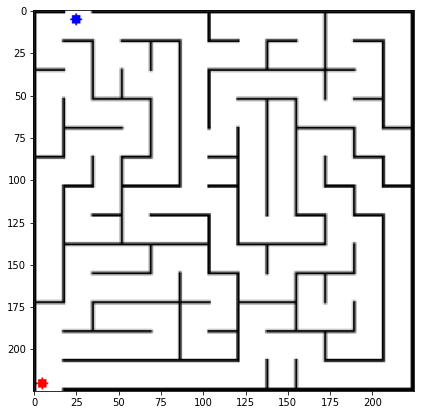

In [ ]:
img = cv2.imread('maze.png') # read the image 
cv2.circle(img,(5,220), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (25,5), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()

# New Section

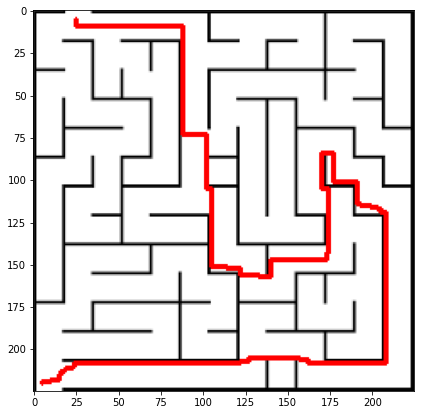

In [ ]:
img = cv2.imread('maze.png') # read image
cv2.imwrite('maze-initial.png', img)
p = find_shortest_path(img, (25,5), (5,220))
drawPath(img,p)
cv2.imwrite('maze-solution.png', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()

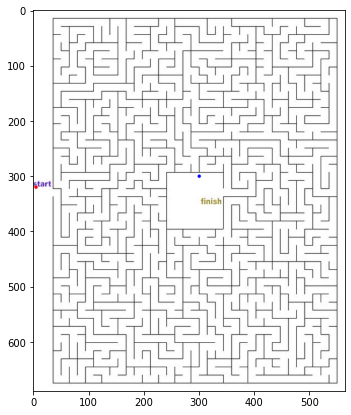

In [ ]:
img = cv2.imread('maze5.jpg') # read the image 
cv2.circle(img,(5,320), 3, (255,0,0), -1) # add a circle at (5, 220)
cv2.circle(img, (300,300), 3, (0,0,255), -1) # add a circle at (5,5)
plt.figure(figsize=(7,7))
plt.imshow(img)  
plt.show()

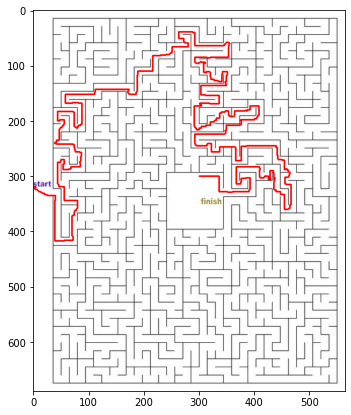

In [ ]:
img = cv2.imread('maze5.jpg') # read image
cv2.imwrite('maze-initial5.jpg', img)
p = find_shortest_path(img, (300,300), (5,320))
drawPath(img,p)
cv2.imwrite('maze-solution5.jpg', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()

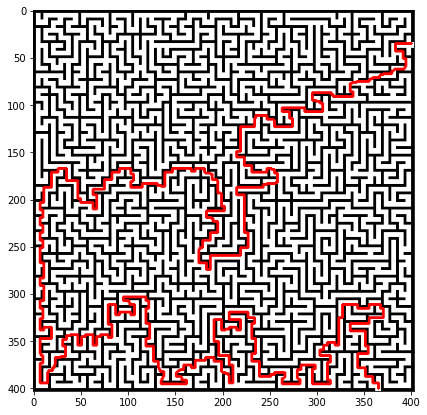

In [ ]:
img = cv2.imread('maze2.png') # read image
cv2.imwrite('maze-initial2.png', img)
#cv2.circle(img,(400,35), 3, (255,0,0), -1) # add a circle at (5, 220)
p = find_shortest_path(img, (365,400), (400,35))
drawPath(img,p)
cv2.imwrite('maze-solution5.jpg', img)
plt.figure(figsize=(7,7))
plt.imshow(img) # show the image on the screen 
plt.show()